In [50]:
! pip install pillow
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install opencv-python

You should consider upgrading via the 'c:\users\t.nurgaliev\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\t.nurgaliev\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\t.nurgaliev\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\t.nurgaliev\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\t.nurgaliev\pycharmprojects\pythonproject\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [100]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

In [53]:
images = [cv.imread(f'0{i}.tif', cv.IMREAD_GRAYSCALE) for i in range(1, 10)] \
+ [cv.imread(f'{i}.tif', cv.IMREAD_GRAYSCALE) for i in range(10, 13)]

#### Нахождение ОТ и вычисление дескрипторов

In [74]:
def calc_descriptors(img, detector):
    if detector == 'ORB':
        # Initiate ORB detector
        orb = cv.ORB_create()
        # find the keypoints and descriptors with ORB
        kp, des = orb.detectAndCompute(img, None)
        return des
    elif detector == 'SIFT':
        # Initiate SIFT detector
        sift = cv.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp, des = sift.detectAndCompute(img, None)
        return des
    elif detector == 'HARRIS':
        des = cv.cornerHarris(img, 2, 3, 0.04)
        return des
    else:
        return []

#### Поиск соответствий между парами ОТ

In [55]:
from scipy.spatial.distance import hamming
from numpy.linalg import norm as l2

hamming_norm = lambda x, y: hamming(x, y) * len(x)
l2_norm = lambda x, y: l2(x - y)

norms = {'ORB': hamming_norm,
         'SIFT': l2_norm,
         'HARRIS': l2_norm }

In [56]:
def min_idx_by(elem, arr, norm):
    """
    :param elem: array[n]
    :param arr: array[len, n]
    :param norm: distance measurement
    :returns: idx of arr elem with minimal distance to elem
    """
    return np.argmin(list(map(lambda x: norm(elem, x), arr)))

In [57]:
def calc_matches(descriptors1, descriptors2, detector):
    """
    :params descriptors1, descriptors2: array[keypoints_number, n] - keypoints descriptors
    :param detector: used detector type (to choose correct distance measurement)
    :returns: For each keypoint of the first image (descriptors1)
                - whether it was found in the second one (descriptors2).
              Two keypoints (i,j) match if i-th descriptor in descriptors1
              has j-th descriptor in descriptors2 as the best match and vice-versa.
    """
    matches = np.zeros(len(descriptors1))
    norm = norms[detector]
    for i, des1 in enumerate(descriptors1):
        match = min_idx_by(des1, descriptors2, norm)
        matches[i] = min_idx_by(descriptors2[match], descriptors1, norm) == i
    return matches        

#### Подсчет воспроизводимостей

In [79]:
def calc_repeatabilities(images, detector):
    descriptors = list(map(lambda x: calc_descriptors(x, detector), images))
    repeatabilities = []
    for i, des1 in enumerate(descriptors):
        matches = np.zeros(len(des1), dtype=np.float32)
        for j, des2 in enumerate(descriptors):
            if i == j:
                continue
            matches += calc_matches(des1, des2, detector)
        matches /= len(images) - 1
        repeatabilities.append(np.mean(matches))
    return repeatabilities

In [80]:
sift_repeatabilities = calc_repeatabilities(images, 'SIFT')

In [82]:
orb_repeatabilities = calc_repeatabilities(images, 'ORB')

In [83]:
harris_repeatabilitites = calc_repeatabilities(images, 'HARRIS')

In [85]:
repeatabilities = {'HARRIS': harris_repeatabilitites, 
                   'ORB': orb_repeatabilities, 
                   'SIFT': sift_repeatabilities}

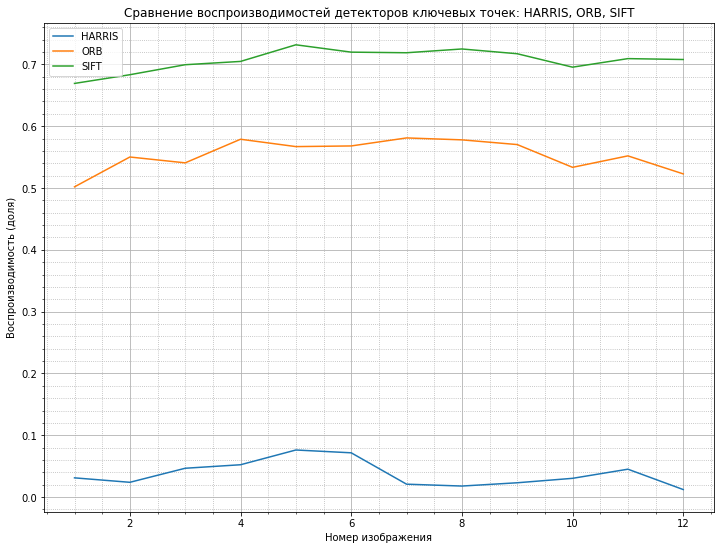

In [90]:
image_numbers = np.arange(1, 13)
fig, ax = plt.subplots(figsize=(12,9))

for detector, rep in repeatabilities.items():
    ax.plot(image_numbers, rep, label=detector)

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', 
        linestyle = ':')
plt.title('Сравнение воспроизводимостей детекторов ключевых точек: HARRIS, ORB, SIFT')
plt.xlabel('Номер изображения')
plt.ylabel('Воспроизводимость (доля)')
plt.legend()
plt.show()

#### Подсчет времени работы

In [105]:
def measure_time(images, detector):
    start_time = time.time()
    descriptors = list(map(lambda x: calc_descriptors(x, detector), images))
    end_time = time.time()
    n_points = np.sum(list(map(len, descriptors)))
    return (end_time - start_time) / n_points

In [106]:
sift_time = measure_time(images, 'SIFT')
orb_time = measure_time(images, 'ORB')
harris_time = measure_time(images, 'HARRIS')

In [107]:
times = {'HARRIS': harris_time, 
         'ORB': orb_time, 
         'SIFT': sift_time}

In [115]:
print("Время работы детектора (на одну ОТ):")
for detector, det_time in times.items():
    print(f"    {detector}: {det_time * 1000:.5f} мсек")

Время работы детектора (на одну ОТ):
    HARRIS: 0.00728 мсек
    ORB: 0.00784 мсек
    SIFT: 0.03773 мсек
